# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 1 Million brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc

import cugraph

import warnings
warnings.filterwarnings("ignore")

In [2]:
import gc

In [3]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read("../2024_gpu_severin.dicks/notebooks/h5/1Million.h5ad")

CPU times: user 1.4 s, sys: 7.27 s, total: 8.67 s
Wall time: 13.4 s


In [6]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 1.23 s, sys: 4.8 s, total: 6.03 s
Wall time: 8.62 s


Verify the shape of the resulting sparse matrix:

In [7]:
adata.shape

(1000000, 27998)

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 22.17888116836548


## Preprocessing

In [9]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [10]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 3.62 ms, sys: 2.49 ms, total: 6.11 ms
Wall time: 437 ms


In [11]:
%%time
rsc.pp.calculate_qc_metrics(adata,qc_vars=["MT"])

CPU times: user 122 ms, sys: 33.3 ms, total: 155 ms
Wall time: 2.96 s


In [12]:
%%time
#sc.pl.scatter(adata,"total_counts","pct_counts_MT")
#sc.pl.scatter(adata,"total_counts","n_genes_by_counts")

CPU times: user 2 μs, sys: 3 μs, total: 5 μs
Wall time: 8.11 μs


In [13]:
%%time
#sc.pl.violin(adata,keys="n_genes_by_counts")
#sc.pl.violin(adata,keys="total_counts")
#sc.pl.violin(adata,keys="pct_counts_MT")

CPU times: user 2 μs, sys: 3 μs, total: 5 μs
Wall time: 8.82 μs


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["n_genes_by_counts"] > 500]

adata.shape

CPU times: user 69.3 ms, sys: 26.4 ms, total: 95.7 ms
Wall time: 1.02 s


(982983, 27998)

In [15]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20].copy()
adata.shape

CPU times: user 168 ms, sys: 88.1 ms, total: 256 ms
Wall time: 1.77 s


(982490, 27998)

In [16]:
gc.collect()

543

We also filter out genes that are expressed in less than 3 cells.

In [17]:
%%time
rsc.pp.filter_genes(adata,min_count=3)

filtered out 5401 genes based on n_cells_by_counts
CPU times: user 396 ms, sys: 85.5 ms, total: 482 ms
Wall time: 854 ms


We store the raw expression counts in the `.layer["counts"]`

In [18]:
adata.layers["counts"] = adata.X.copy()

In [19]:
adata.shape

(982490, 22597)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
rsc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 1.14 ms, sys: 1.18 ms, total: 2.32 ms
Wall time: 150 ms


Next, we log transform the count matrix.

In [21]:
%%time
rsc.pp.log1p(adata)

CPU times: user 32.3 ms, sys: 11.9 ms, total: 44.2 ms
Wall time: 64 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [22]:
%%time
rsc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",layer = "counts")

CPU times: user 275 ms, sys: 63.7 ms, total: 339 ms
Wall time: 3.16 s


Now we safe this verion of the AnnData as adata.raw.

In [23]:
%%time
#adata.raw = adata

CPU times: user 2 μs, sys: 3 μs, total: 5 μs
Wall time: 7.63 μs


In [24]:
del adata.layers["counts"]

Now we restrict our AnnData object to the highly variable genes.

In [25]:
%%time
adata = adata[:,adata.var["highly_variable"]==True].copy()

CPU times: user 240 ms, sys: 59.9 ms, total: 300 ms
Wall time: 595 ms


In [26]:
gc.collect()

511

In [27]:
adata.shape

(982490, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [28]:
%%time
rsc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 854 ms, sys: 458 ms, total: 1.31 s
Wall time: 2.5 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [29]:
%%time
rsc.pp.scale(adata,max_value=10,zero_center=True)

CPU times: user 102 ms, sys: 7.01 ms, total: 109 ms
Wall time: 419 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `rapids-singlecell` that uses cuMLs PCA to run this.

In [30]:
%%time
rsc.pp.pca(adata, n_comps = 50, use_highly_variable=False)

CPU times: user 1.58 s, sys: 198 ms, total: 1.78 s
Wall time: 9.13 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

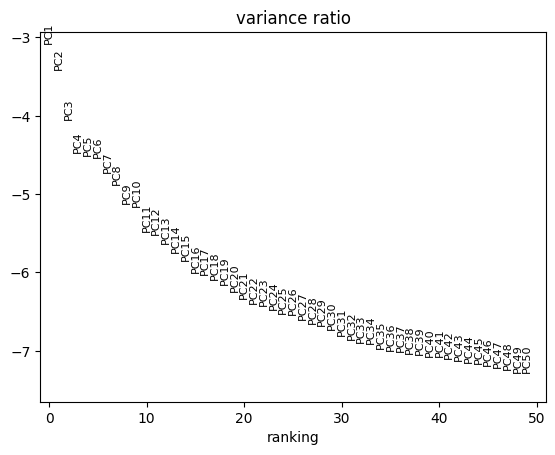

In [31]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

Now we move `.X` and `.layers` out of the GPU.

In [32]:
%%time
rsc.get.anndata_to_CPU(adata, convert_all=True)

CPU times: user 3.1 s, sys: 1.78 s, total: 4.88 s
Wall time: 4.89 s


In [33]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 36.39381384849548


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [34]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

CPU times: user 9.61 s, sys: 223 ms, total: 9.84 s
Wall time: 12.1 s


Next we calculate the UMAP embedding using rapdis.

In [35]:
%%time
rsc.tl.umap(adata)

CPU times: user 1.46 s, sys: 110 ms, total: 1.57 s
Wall time: 4.13 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [36]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 2.18 s, sys: 1.83 s, total: 4 s
Wall time: 23.2 s


In [37]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 1.78 s, sys: 1.04 s, total: 2.82 s
Wall time: 4.59 s


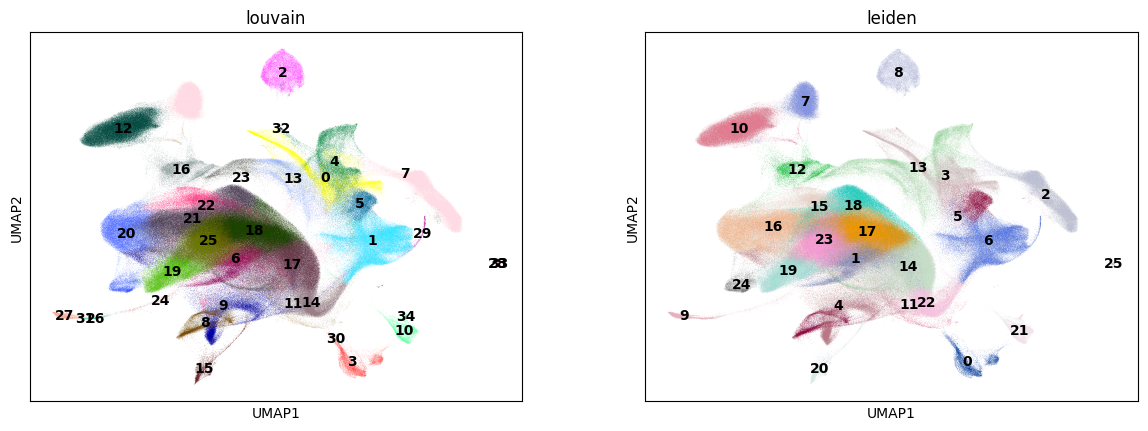

CPU times: user 4.94 s, sys: 262 ms, total: 5.2 s
Wall time: 5.26 s


In [38]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

## TSNE

In [39]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

[W] [14:27:08.468141] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 13.7 s, sys: 3.68 s, total: 17.3 s
Wall time: 18.8 s


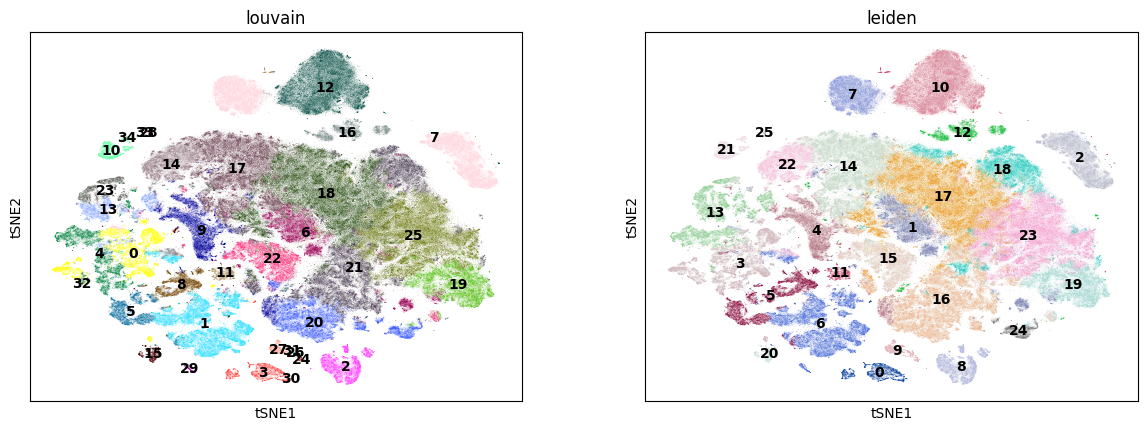

In [40]:
sc.pl.tsne(adata,color=["louvain","leiden"], legend_loc='on data')

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvaincluster.

In [41]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="leiden", use_raw=False)

[W] [14:28:14.025183] L-BFGS: max iterations reached
[W] [14:28:14.026025] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 23 s, sys: 18.4 s, total: 41.4 s
Wall time: 42.6 s


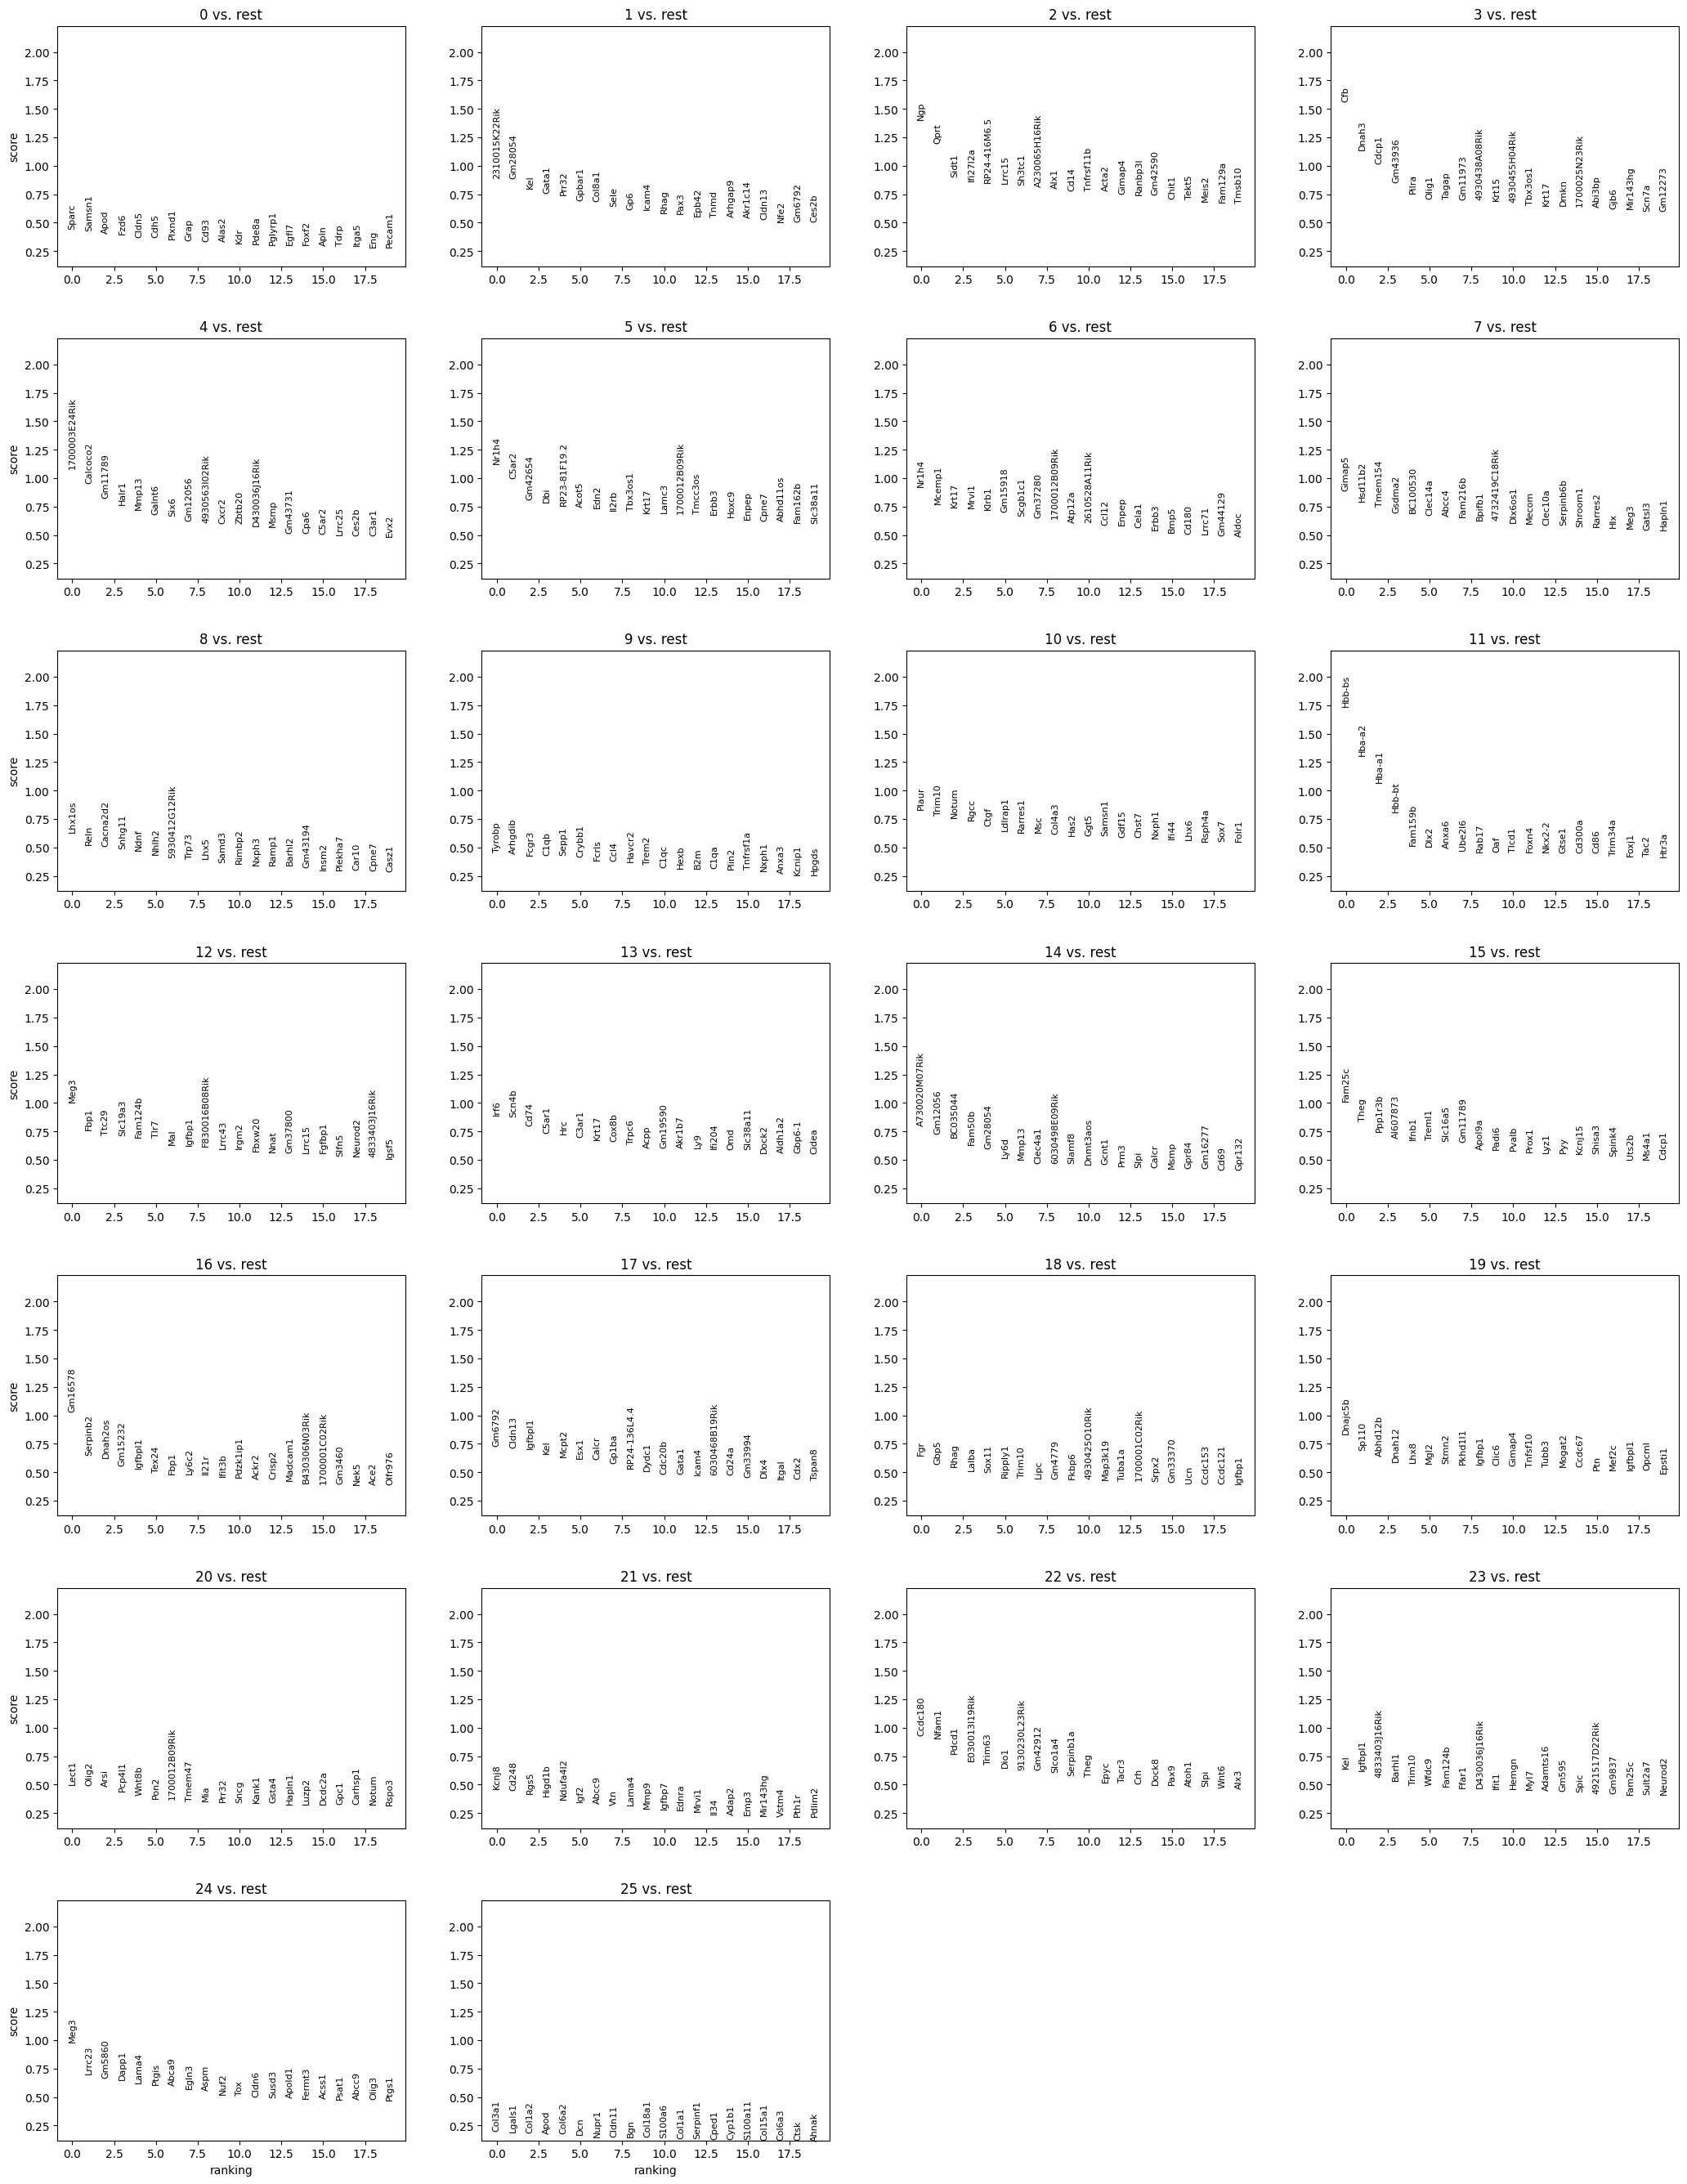

CPU times: user 2.25 s, sys: 632 ms, total: 2.88 s
Wall time: 2.62 s


In [42]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Diffusion Maps

In [43]:
%%time
rsc.tl.diffmap(adata)
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:] 

CPU times: user 1.62 s, sys: 168 ms, total: 1.78 s
Wall time: 2.5 s


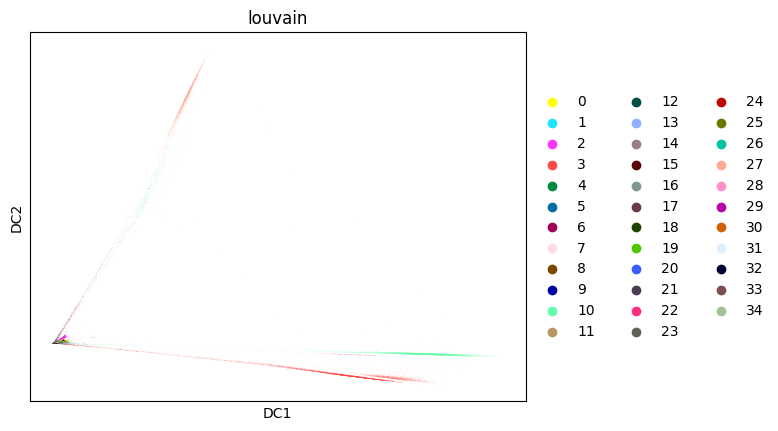

In [44]:
sc.pl.diffmap(adata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [45]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 160.0462007522583
